<a href="https://colab.research.google.com/github/Ndarugaa/Graph-Network-Analysis-for-cell-Organization/blob/main/3_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import Sequence


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# @title Default title text
# !pip install patool
# import patoolib

# patoolib.extract_archive("/content/drive/MyDrive/Graph-Network-Analysis-for-cell-Organization/sliced_images.zip", outdir = "data/sliced_images")


In [4]:
# Step 1: Load CSV file
ROOT_DIR = 'data/sliced_images/sliced_images/'
csv_file = 'filenames.csv'
data = pd.read_csv('filenames.csv', index_col='Unnamed: 0')
data.head()

,images,masks,labels
0,ID319_A1_Regione-0.jp2-crop_slice_17/43_image.png,ID319_A1_Regione-0.jp2-crop_slice_17/55_mask.png,ID319_A1_Regione-0.jp2-crop_slice_17/32_label.tif
1,ID319_A1_Regione-0.jp2-crop_slice_17/48_image.png,ID319_A1_Regione-0.jp2-crop_slice_17/51_mask.png,ID319_A1_Regione-0.jp2-crop_slice_17/2_label.tif
2,ID319_A1_Regione-0.jp2-crop_slice_17/30_image.png,ID319_A1_Regione-0.jp2-crop_slice_17/37_mask.png,ID319_A1_Regione-0.jp2-crop_slice_17/11_label.tif
3,ID319_A1_Regione-0.jp2-crop_slice_17/58_image.png,ID319_A1_Regione-0.jp2-crop_slice_17/29_mask.png,ID319_A1_Regione-0.jp2-crop_slice_17/19_label.tif
4,ID319_A1_Regione-0.jp2-crop_slice_17/53_image.png,ID319_A1_Regione-0.jp2-crop_slice_17/33_mask.png,ID319_A1_Regione-0.jp2-crop_slice_17/31_label.tif


In [5]:
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
print(train_data.shape)
print(test_data.shape)

(2713, 3)
(679, 3)


In [7]:
class CustomDataGenerator(Sequence):
    def __init__(self, data, batch_size, image_size):
        self.data = data
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        batch_data = self.data.iloc[index * self.batch_size: (index + 1) * self.batch_size]
        batch_images = []
        batch_masks = []
        batch_labels = []

        for _, row in batch_data.iterrows():
            img_filename = row['images']
            mask_filename = row['masks']
            label_filename = row['labels']

            img = Image.open(os.path.join(ROOT_DIR, img_filename)).convert('RGB')
            img = img.resize(self.image_size, Image.ANTIALIAS)
            img = np.array(img)

            mask = Image.open(os.path.join(ROOT_DIR, mask_filename)).convert('L')
            mask = mask.resize(self.image_size, Image.NEAREST)
            mask = np.array(mask)
            mask = mask[..., np.newaxis]  # Add a channel dimension to make it (height, width, 1)

            label = Image.open(os.path.join(ROOT_DIR, label_filename))
            label = label.resize(self.image_size, Image.NEAREST)
            label = np.array(label)

            batch_images.append(img)
            batch_masks.append(mask)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_masks), np.array(batch_labels)

In [8]:
batch_size = 32
image_size = (256, 256)

# Create data generators for training and testing
train_generator = CustomDataGenerator(train_data, batch_size, image_size)
test_generator = CustomDataGenerator(test_data, batch_size, image_size)

In [9]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


In [10]:
# Define U-Net Model
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(128, (2, 2), activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(64, (2, 2), activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(32, (2, 2), activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv7)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [11]:
# Create and compile the U-Net model
input_shape = image_size + (3,)  # Assuming RGB images
num_classes = 1  # For binary segmentation (black and white masks)
model = unet_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
# Train the model
epochs = 5
history = model.fit(train_generator, validation_data=test_generator, epochs=epochs, workers=8)


<ipython-input-7-6c8d48478c07>:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.image_size, Image.ANTIALIAS)


Epoch 1/5
84/84 [==============================] - 5688s 68s/step - loss: nan - accuracy: 0.5538 - val_loss: nan - val_accuracy: 0.8745
Epoch 2/5
84/84 [==============================] - 5674s 68s/step - loss: nan - accuracy: 0.8775 - val_loss: nan - val_accuracy: 0.8745
Epoch 3/5
84/84 [==============================] - 5632s 67s/step - loss: nan - accuracy: 0.8775 - val_loss: nan - val_accuracy: 0.8745
Epoch 4/5
84/84 [==============================] - 5599s 67s/step - loss: nan - accuracy: 0.8775 - val_loss: nan - val_accuracy: 0.8745
Epoch 5/5
84/84 [==============================] - 5623s 67s/step - loss: nan - accuracy: 0.8775 - val_loss: nan - val_accuracy: 0.8745


In [13]:
# Save the model for future use
model.save('unet_model.h5')


In [17]:
test_loss, test_accuracy = model.evaluate(test_generator, workers=8)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-7-6c8d48478c07>:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.image_size, Image.ANTIALIAS)


21/21 [==============================] - 365s 17s/step - loss: nan - accuracy: 0.8745
Test Loss: nan
Test Accuracy: 0.8744843602180481


In [18]:
# Make predictions on new image
new_image = Image.open('/content/drive/MyDrive/Graph-Network-Analysis-for-cell-Organization/test_image/1-scimpanze-1dx-2sx_1_slice_4.png').convert('RGB')
new_image = new_image.resize(image_size, Image.ANTIALIAS)
new_image = np.array(new_image)
new_image = np.expand_dims(new_image, axis=0)  # Add a batch dimension


<ipython-input-18-74b581104d25>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_image = new_image.resize(image_size, Image.ANTIALIAS)


In [19]:
# Make predictions
predictions = model.predict(new_image)


1/1 [==============================] - 1s 1s/step


In [20]:
# convert predictions to binary mask (0 or 1)
binary_mask = (predictions > 0.5).astype(np.uint8)[0, ..., 0]  # Convert to (height, width)


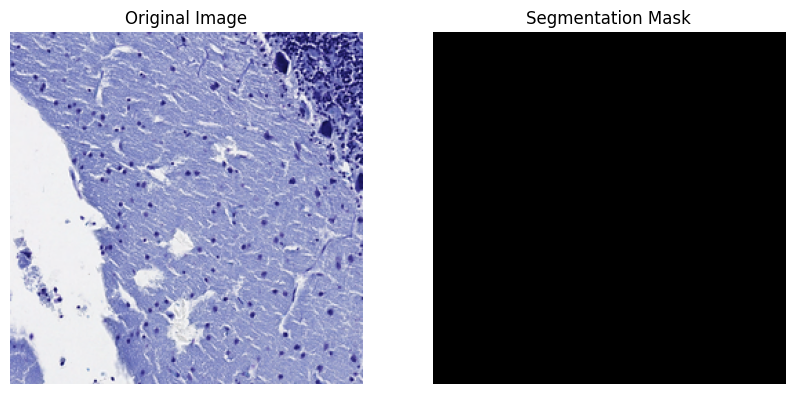

In [21]:
import matplotlib.pyplot as plt

# Visualize the image and segmentation mask
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(new_image[0])
plt.title('Original Image')
plt.axis('off')

# Segmentation Mask
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

In [ ]:
test_image_path = '/content/drive/MyDrive/Graph-Network-Analysis-for-cell-Organization/test_image/sliced'
image_size = (512, 512)

for imgs in os.listdir(test_image_path):
  new_image = Image.open(os.path.join(test_image_path, imgs)).convert('RGB')
  new_image = new_image.resize(image_size, Image.ANTIALIAS)
  new_image = np.array(new_image)
  new_image = np.expand_dims(new_image, axis=0)
  predictions = model.predict(new_image)
  print('\n\n'+'*'*50)
  binary_mask = (predictions > 0.5).astype(np.uint8)[0, ..., 0]  # Convert to (height, width)
  # Visualize the image and segmentation mask
  plt.figure(figsize=(10, 5))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(new_image[0])
  plt.title('Original Image')
  plt.axis('off')

  # Segmentation Mask
  plt.subplot(1, 2, 2)
  plt.imshow(binary_mask, cmap='gray')
  plt.title('Segmentation Mask')
  plt.axis('off')

  plt.show()


In [27]:
unet_model = load_model('unet_model.h5')

In [33]:
import os
import pandas as pd
import numpy as np
from skimage import io, color, measure, feature
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
from keras.models import load_model
import cv2

In [34]:
def extract_features(component):
    """
    extract features from an individual segmented component

    Args:
        components: the extracted components
    return:
        Extracted features
    """

    if len(component.shape) == 3: # Convert the component to grayscale if needed
        component = color.rgb2gray(component)

    # Check if any regions were detected
    labeled_components = measure.label(component.astype(int))
    if labeled_components.max() == 0:
        num_features = 14  # 4 shape features, 8 LBP features, mean_intensity, std_intensity
        return [0.0] * num_features

    # Shape Features
    props = regionprops(labeled_components)[0]
    area = props.area
    perimeter = props.perimeter
    eccentricity = props.eccentricity
    solidity = props.solidity

    # Texture Features - Using Local Binary Patterns (LBP) as an example
    lbp = feature.local_binary_pattern(component, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 9), range=(0, 9))
    lbp_features = hist_lbp.astype(float)

    # Intensity Features
    mean_intensity = component.mean()
    std_intensity = component.std()

    # Combine all features into a single feature vector
    features = [area, perimeter, eccentricity, solidity]
    features.extend(lbp_features)
    features.extend([mean_intensity, std_intensity])

    return features

In [ ]:
features_list = []

for _, row in data.iterrows():
    image_filename = row['images']
    mask_filename = row['masks']
    label = row['labels']

    image = io.imread(os.path.join(ROOT_DIR, image_filename))
    mask = io.imread(os.path.join(ROOT_DIR, image_filename))

    # Convert the image and mask to the same data type (uint8) for bitwise_and
    image = image.astype(np.uint8)
    mask = mask.astype(np.uint8)

    # Apply the mask to the image to extract the region of interest
    # segmented_component = cv2.bitwise_and(image, image, mask=mask)
    segmented_component = image.copy()
    segmented_component[mask == 0] = 0
    resized_image = cv2.resize(segmented_component, (256, 256))
    normalized_image = resized_image / 255.0
    input_image = np.expand_dims(normalized_image, axis=0)

    # Perform cell segmentation using U-Net
    segmented_cells = unet_model.predict(input_image)[0]

    cell_labels = np.unique(segmented_cells)
    for label in cell_labels:
        cell_mask = (segmented_cells == label).astype(np.uint8)
        cell_image = cv2.bitwise_and(segmented_component, segmented_component, mask=cell_mask)
        features = extract_features(cell_image)
        if 'labels' in data.columns:
            features.append(row['labels'])

        features_list.append(features)


In [41]:
#---------------------GET PANDAS DATAFRAME-------------------------#

# Convert the features_list to a pandas DataFrame
feature_columns = ['area', 'perimeter', 'eccentricity', 'solidity']
lbp_columns = [f'lbp_{i}' for i in range(8)]  # LBP features
intensity_columns = ['mean_intensity', 'std_intensity']

print('\n\n'+'*'*30 + " FEATURES DATAFRAME " + '*'*30)
features_df = pd.DataFrame(features_list, columns=feature_columns + lbp_columns + intensity_columns + ['label'])
print(features_df.tail(5))
print("\nshape: ", features_df.shape)
features_df.to_csv('extracted_features.csv')



****************************** FEATURES DATAFRAME ******************************
      area  perimeter  eccentricity  solidity  lbp_0  lbp_1  lbp_2  lbp_3  \
3387   0.0        0.0           0.0       0.0    0.0    0.0    0.0    0.0   
3388   0.0        0.0           0.0       0.0    0.0    0.0    0.0    0.0   
3389   0.0        0.0           0.0       0.0    0.0    0.0    0.0    0.0   
3390   0.0        0.0           0.0       0.0    0.0    0.0    0.0    0.0   
3391   0.0        0.0           0.0       0.0    0.0    0.0    0.0    0.0   

      lbp_4  lbp_5  lbp_6  lbp_7  mean_intensity  std_intensity  \
3387    0.0    0.0    0.0    0.0             0.0            0.0   
3388    0.0    0.0    0.0    0.0             0.0            0.0   
3389    0.0    0.0    0.0    0.0             0.0            0.0   
3390    0.0    0.0    0.0    0.0             0.0            0.0   
3391    0.0    0.0    0.0    0.0             0.0            0.0   

                                                  l